In [1]:
from src.util_tools import compute_cross_entropy
from tools.project import INPUT_PATH, LOGS_PATH, OUTPUT_PATH

import audiocraft
from audiocraft.models import MusicGen
from audiocraft.utils.notebook import display_audio
import torch
from gradio.cli.commands.components.publish import colors
from omegaconf import DictConfig
from torch import set_grad_enabled
from torch.onnx.symbolic_opset9 import tensor
from torchviz import make_dot
import typing as tp
from audiocraft.modules.conditioners import ConditioningAttributes
import tqdm
import torch
from audiocraft.data.audio import audio_read, audio_write
from audiocraft.data.audio_utils import convert_audio_channels, convert_audio
import umap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from random import shuffle
from torch.utils.data import TensorDataset, random_split, DataLoader
EXP_NUM = 1
EXAMPLES_LEN = 5
BATCH_SIZE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [5]:
model = MusicGen.get_pretrained('facebook/musicgen-small')
model.set_generation_params(
	use_sampling=True,
	top_k=250,
	duration=EXAMPLES_LEN
)

/Users/mszawerda/Library/Caches/pypoetry/virtualenvs/musicgen-YATmys4o-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [2]:
def get_music(idxs):
	songs = []
	for p in idxs:
		music, sr = audio_read(INPUT_PATH('textual-inversion', '8bit', f'music_p{p}.wav'), duration=EXAMPLES_LEN, pad=True)
		music = music[None]
		songs.append(convert_audio(music, sr, 32000, 1))
	with torch.no_grad():
		encoded_music, _ = model.compression_model.encode(torch.concatenate(songs).to(DEVICE))
	return encoded_music
def load_music_to_pt():
	return torch.concatenate([get_music(range(i, i+10)) for i in range(0, 230, 10)])
dl = lambda x, s: DataLoader(x, batch_size=BATCH_SIZE, shuffle=s, pin_memory=True if torch.cuda.is_available() else False)
# torch.save(load_music_to_pt(), INPUT_PATH('textual-inversion', '8bit', 'encoded.pt'))
ds=torch.load(INPUT_PATH('textual-inversion', '8bit', 'encoded.pt'))[:225, :, :]
ds = TensorDataset(ds)
train_ds, val_ds = random_split(ds, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_dl, val_dl = dl(train_ds, True), dl(val_ds, False)

In [7]:
new_token="S*"
text_conditioner=list(model.lm.condition_provider.conditioners.values())[0]
tokenizer=text_conditioner.t5_tokenizer
text_model=text_conditioner.t5.to(DEVICE)
new_token_id = tokenizer.convert_tokens_to_ids(new_token)

if tokenizer.add_tokens([new_token]) == 1:
	text_model.resize_token_embeddings(len(tokenizer))
	with torch.no_grad():
		text_model.shared.weight[new_token_id] = text_model.shared.weight.mean(dim=0)

In [8]:
train_desc = [
    "the sound of a S*", 
    "high quality S* audio", 
    "the S* recording",
    "the sound of a S*", 
    "high quality S* audio"
]

val_desc = [
    "a S* recording",
    "a cool S* audio",
    "In the style of S*",
    "Simillar to S*",
    "a cropped recording of a S*"
]

val_desc = [
    ConditioningAttributes(text={'description': x})
    for x in val_desc
]

assert len(train_desc)==BATCH_SIZE and len(val_desc)==BATCH_SIZE

In [9]:
lm = model.lm
lm.requires_grad_(True)
text_model.requires_grad_(True)
text_conditioner.finetune=True

def zero_existing_emb(grad):
	mask = torch.zeros_like(grad)
	mask[new_token_id] = 10.0
	return grad * mask
text_model.shared.weight.register_hook(zero_existing_emb)

target = text_model.shared.weight
old_target = target[new_token_id].detach().clone()
writer = SummaryWriter(LOGS_PATH('textual-inversion', f'{EXP_NUM}'))
EXP_NUM += 1
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
val_step = False

text_conditioner = list(lm.condition_provider.conditioners.values())[0]
lr = 1e-1
optimizer = torch.optim.Adam([target], lr=lr)
epochs = 100
target_path = []

tokenized_desc = {
	k: v.to(DEVICE)
	for k,v in tokenizer(train_desc, return_tensors='pt', padding=True, add_special_tokens=False).items()
}
mask = tokenized_desc['attention_mask'].to(DEVICE)

with tqdm.tqdm(total=epochs) as pbar:
	for epoch in range(epochs):
		target_path.append(target[new_token_id].detach().clone())
		total_loss = 0
		num_batches = len(train_dl)
		for i, music_batch in enumerate(train_dl):
			music_batch = music_batch[0].to(DEVICE)
			optimizer.zero_grad()
			with text_conditioner.autocast and torch.set_grad_enabled(True):
				embeds = text_model(**tokenized_desc).last_hidden_state
			embeds = text_conditioner.output_proj(embeds.to(text_conditioner.output_proj.weight))
			embeds = (embeds * mask.unsqueeze(-1))
			with model.autocast:
				out = lm.compute_predictions(music_batch, [], {'description': (embeds, mask)})
			loss, _ = compute_cross_entropy(out.logits, music_batch, out.mask)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
			pbar.set_description(f'train {i}/{num_batches}')
		writer.add_scalar('avg loss', total_loss/num_batches, epoch)
		# writer.add_scalar('grad norm', target[new_token_id].grad.norm().item(), i)
		
		if epoch % 10==0 and val_step:
			with torch.no_grad():
				total_loss = 0
				num_batches = len(val_dl)
				for music_batch in val_dl:
					music_batch = music_batch[0].to(DEVICE)
					with model.autocast:
						val_out = lm.compute_predictions(music_batch, val_desc)
					val_loss, _ = compute_cross_entropy(val_out.logits, music_batch, val_out.mask)
					total_loss += val_loss
					pbar.set_description(f'val {i}/{num_batches}')
				writer.add_scalar('avg val loss', total_loss/num_batches, epoch)
				res=model.generate(["In the style of "+new_token]*5)
				for a_idx in range(res.shape[0]):
					music = res[a_idx].cpu()
					writer.add_audio(f'Audio {a_idx}', music/np.max(np.abs(music.numpy())), epoch, model.cfg.sample_rate)
		pbar.set_postfix_str(f'epoch: {epoch}, grad_norm: {target.grad.norm().item():.3f}, loss: {loss.item():.3f}')
		pbar.update(1)
	target_path.append(target[new_token_id].detach().clone())
writer.close()
torch.norm(target[new_token_id].detach().clone()-old_target)

train 26/36:  13%|█▎        | 13/100 [25:19<2:49:29, 116.89s/it, epoch: 35, grad_norm: 0.004, loss: 3.405]


KeyboardInterrupt: 

## Eval

In [26]:
res=model.generate(["music with S*"]*5, progress=True)
display_audio(res,model.cfg.sample_rate )
# for i, audio in enumerate(res):
# 	audio_write(OUTPUT_PATH('textual-inversion', f'out_{i}'), audio, model.cfg.sample_rate)

In [24]:
sentences = [
	"Dog",
	"S*",
	"bass and guitar",
	"post rock",
	"8bit",
	"games"
]

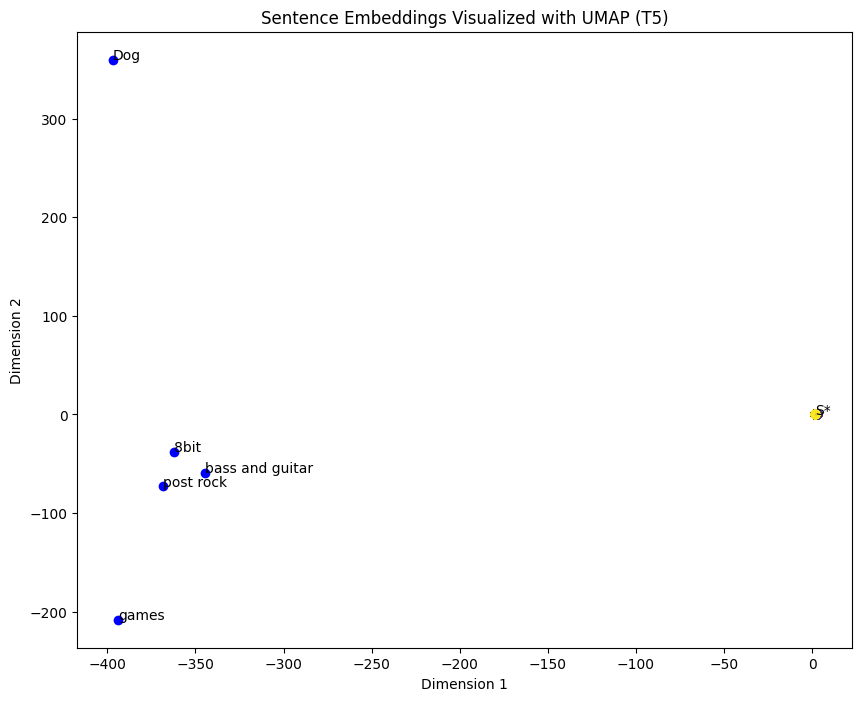

In [25]:
# Tokenize sentences
inputs = tokenizer(sentences, return_tensors='pt', padding=True, add_special_tokens=False)

# Get encoder outputs
with torch.no_grad():
	outputs= text_model.encoder.embed_tokens(inputs['input_ids'].to(DEVICE))
# outputs = text_model(**inputs)


# Compute attention mask
attention_mask = inputs['attention_mask']
attention_mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.size()).float()

# Average pooling
sum_embeddings = torch.sum(outputs * attention_mask_expanded.to(DEVICE), dim=1)
sum_mask = torch.clamp(attention_mask_expanded.sum(dim=1), min=1e-9).to(DEVICE)
sentence_embeddings = sum_embeddings / sum_mask

# Convert to NumPy
sentence_embeddings = sentence_embeddings.cpu().numpy()

# Dimensionality reduction
dim_input = np.concatenate([np.stack([x.cpu() for x in target_path]), sentence_embeddings])
# reducer = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine')
# embeddings_2d = reducer.fit_transform(dim_input)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(dim_input)

# Plotting
sentence_idx = len(target_path)
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[sentence_idx:, 0], embeddings_2d[sentence_idx:, 1], c='blue')

for i, sentence in enumerate(sentences):
	plt.annotate(sentence, (embeddings_2d[i+sentence_idx, 0], embeddings_2d[i+sentence_idx, 1]))

colors = cm.viridis(np.linspace(0, 1, sentence_idx))
colors[:, 3]=colors[:, 3]-0.5


for (x,y), c in zip(embeddings_2d[:sentence_idx], colors):
	plt.scatter(x, y, color=c)
plt.plot([x[0] for x in embeddings_2d[:sentence_idx]], [x[1] for x in embeddings_2d[:sentence_idx]], ':g', alpha=0.2)



plt.title('Sentence Embeddings Visualized with UMAP (T5)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()